RANDOM CROSS VALIDATION

In [16]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [17]:
import xarray as xr

nh3_nc = xr.load_dataset('../datasets/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly_lombardia.nc') # Copernicus (0.1°x0.1°)

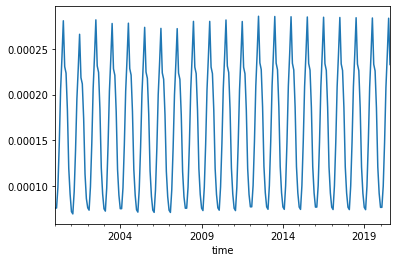

In [18]:
from utils import utils
import matplotlib.pyplot as plt

nh3 = utils.xarray2pandas(nh3_nc.agl, 6, 17).to_period('M')
nh3.plot()
plt.show()

In [19]:
import random

random.seed(0)

def random_training_validation_window(ts, size, validation_size):

    n = len(ts)

    start = random.randint(0, int(n*(1-size)) - validation_size)
    end = start + int(n*size)
    return ts[start:end], ts[end:end+validation_size]

In [20]:
def multiple_forecasts(model, ts, times, refit=False):
    
    predictions = []
    errors = []

    for i in range(len(ts)):
        prediction = model.forecast()
        model = model.append([prediction.values[0]], refit=refit)
        predictions.append(prediction.values[0])
        errors.append(ts.values[i] - prediction.values[0])
    
    return predictions, errors

In [21]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import ccf

def random_cross_validation(ts, order, seasonal_order, times=1, verbose=False):

    aics = []
    bics = []
    rmses = []
    sses = []
    mses = []
    ccfs_year_is = []
    ccfs_year_oos = []

    for i in range(times):
        train_months = 180
        validation_months = 12
        train_data, validation_data = random_training_validation_window(nh3, train_months/len(nh3), validation_months)

        assert(len(train_data) == train_months)
        assert(len(validation_data) == validation_months)

        model = ARIMA(endog=train_data, order=order, seasonal_order=seasonal_order).fit()

        aics.append(model.aicc)
        bics.append(model.bic)

        # out of sample
        predictions, errors = multiple_forecasts(model=model, ts=validation_data, times=len(validation_data), refit=False)
        rmse = np.sqrt(np.mean(((predictions - validation_data.values) ** 2)))
        rmses.append(rmse)

        sses.append(model.sse)
        mses.append(model.mse)
        ccfs_year_is.append(ccf(errors, errors)[:][11])
        ccfs_year_oos.append(ccf(model.resid, model.resid)[:][12])
    
    return np.mean(rmses), np.mean(aics), np.mean(bics), np.mean(sses),  np.mean(mses), np.mean(np.abs(acf(model.resid))), np.mean(ccfs_year_is), np.mean(ccfs_year_oos)

In [22]:
# SARIMAX(p,d,q,P,D,Q,s)

import numpy as np
from statsmodels.tsa.stattools import acf

def model_selection(ts, cv_iterations=1, verbose=False):
    
    p_list = [0,1,2,3,4,5,6, [1,2,5,6], [1,6], [1,5,6]]
    q_list = [0,1,2,3,4,5,6]
    P_list = [1]
    Q_list = [0, 1]
    s_list = [12]

    results = {}
    idx = 0

    for p in p_list:
       for q in q_list:
            for P in P_list:
                for Q in Q_list:
                    for s in s_list:
                        model_name = 'SARIMA(p={}, d=0, q={}, P={}, D=0, Q={}, s={})'.format(p, q, P, Q, s)
                        model_idx = idx

                        if verbose: print('{}: {}'.format(model_idx, model_name))
                        
                        rmse, aic, bic, sse, mse, meaacf, ccfis, ccfoos = random_cross_validation(ts=ts, order=(p,0,q), seasonal_order=(P,0,Q,s),                                                                                    times=cv_iterations)

                        results[model_name] = {
                            'order' : (p,0,q),
                            'seasonal_order' : (P,0,Q,s),
                            'aic' : aic,
                            'bic' : bic,
                            'sse' : sse,
                            'rmse' : rmse,
                            'mse' : mse,
                            'index' : model_idx,
                            'mean_abs_acf': meaacf,
                            'ccfis' : ccfis,
                            'ccdoos': ccfoos     
                            }

                        idx += 1
                    
                    
    return results

In [23]:
results = model_selection(nh3, cv_iterations=1, verbose=True)

0: SARIMA(p=0, d=0, q=0, P=1, D=0, Q=0, s=12)
1: SARIMA(p=0, d=0, q=0, P=1, D=0, Q=1, s=12)
2: SARIMA(p=0, d=0, q=1, P=1, D=0, Q=0, s=12)
3: SARIMA(p=0, d=0, q=1, P=1, D=0, Q=1, s=12)
4: SARIMA(p=0, d=0, q=2, P=1, D=0, Q=0, s=12)
5: SARIMA(p=0, d=0, q=2, P=1, D=0, Q=1, s=12)
6: SARIMA(p=0, d=0, q=3, P=1, D=0, Q=0, s=12)
7: SARIMA(p=0, d=0, q=3, P=1, D=0, Q=1, s=12)
8: SARIMA(p=0, d=0, q=4, P=1, D=0, Q=0, s=12)
9: SARIMA(p=0, d=0, q=4, P=1, D=0, Q=1, s=12)
10: SARIMA(p=0, d=0, q=5, P=1, D=0, Q=0, s=12)
11: SARIMA(p=0, d=0, q=5, P=1, D=0, Q=1, s=12)
12: SARIMA(p=0, d=0, q=6, P=1, D=0, Q=0, s=12)
13: SARIMA(p=0, d=0, q=6, P=1, D=0, Q=1, s=12)
14: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=0, s=12)
15: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=1, s=12)
16: SARIMA(p=1, d=0, q=1, P=1, D=0, Q=0, s=12)
17: SARIMA(p=1, d=0, q=1, P=1, D=0, Q=1, s=12)
18: SARIMA(p=1, d=0, q=2, P=1, D=0, Q=0, s=12)
19: SARIMA(p=1, d=0, q=2, P=1, D=0, Q=1, s=12)
20: SARIMA(p=1, d=0, q=3, P=1, D=0, Q=0, s=12)
21: SARIMA(p=1, d=0, q=

In [25]:
aics = [v['aic'] for k, v in results.items()]
bics = [v['bic'] for k, v in results.items()]
rmses = [v['rmse'] for k, v in results.items()]
sses = [v['sse'] for k, v in results.items()]
mses = [v['mse'] for k, v in results.items()]
maacf = [v['mean_abs_acf'] for k, v in results.items()]
ccfis = [v['ccfis'] for k, v in results.items()]
ccfoos = [v['ccdoos'] for k, v in results.items()]

In [26]:
def tick(order, seasonal_order):
    p, d, q = order
    P, D, Q, s = seasonal_order
    return str((p,q,P,Q))

ticks = [tick(v['order'], v['seasonal_order']) for k, v in sorted(results.items(), key=lambda item: item[1]['index'])]

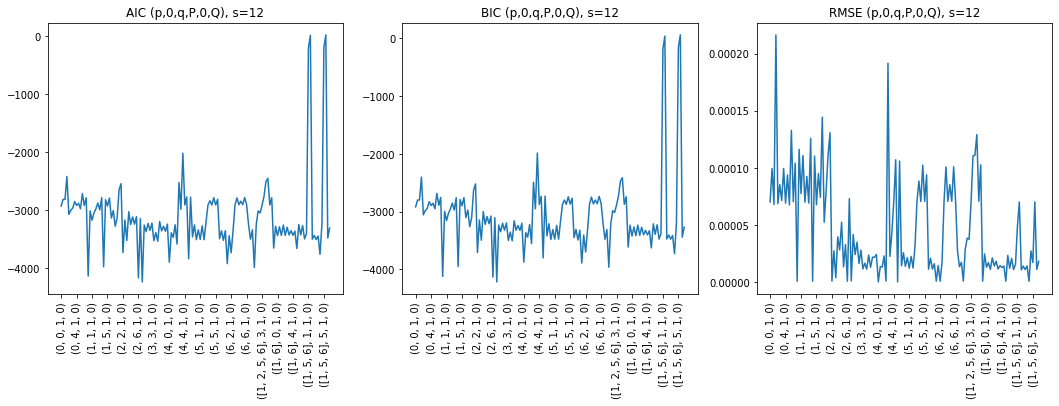

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
indices = np.arange(0, len(results), 8)

axs[0].plot(aics)
axs[0].set_title('AIC (p,0,q,P,0,Q), s=12')
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1].plot(bics)
axs[1].set_title('BIC (p,0,q,P,0,Q), s=12')
axs[1].set_xticks(indices)
axs[1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[2].plot(rmses)
axs[2].set_title('RMSE (p,0,q,P,0,Q), s=12')
axs[2].set_xticks(indices)
axs[2].set_xticklabels(np.array(ticks)[indices], rotation=90)

plt.show()

In [28]:
print('min AIC: {}, min BIC {}, min RMSE {}'.format(np.argmin(aics), np.argmin(bics), np.argmin(rmses)))

min AIC: 42, min BIC 42, min RMSE 66


In [29]:
min_aic_model = [v for k,v in results.items() if v['aic'] == np.min(aics)][0]
min_aic_model

{'order': (3, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -4238.457681258066,
 'bic': -4219.785489285673,
 'sse': 7.430362020489099e-09,
 'rmse': 1.066592501109961e-06,
 'mse': 4.127978900271722e-11,
 'index': 42,
 'mean_abs_acf': 0.06694859471289857,
 'ccfis': 0.3986026834370434,
 'ccdoos': -0.020652641311722075}

In [30]:
min_bic_model = [v for k,v in results.items() if v['bic'] == np.min(bics)][0]
min_bic_model

{'order': (3, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -4238.457681258066,
 'bic': -4219.785489285673,
 'sse': 7.430362020489099e-09,
 'rmse': 1.066592501109961e-06,
 'mse': 4.127978900271722e-11,
 'index': 42,
 'mean_abs_acf': 0.06694859471289857,
 'ccfis': 0.3986026834370434,
 'ccdoos': -0.020652641311722075}

In [31]:
min_rmse_model = [v for k,v in results.items() if v['rmse'] == np.min(rmses)][0]
min_rmse_model

{'order': (4, 0, 5),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3838.823460071476,
 'bic': -3802.3762413338472,
 'sse': 6.036789014280872e-08,
 'rmse': 1.6235864745373289e-07,
 'mse': 3.3537716746004845e-10,
 'index': 66,
 'mean_abs_acf': 0.12790052119447748,
 'ccfis': 1.3458377851429109,
 'ccdoos': -0.07951653676477054}

In [32]:
min_sse_model = [v for k,v in results.items() if v['sse'] == np.min(sses)][0]
min_sse_model

{'order': ([1, 2, 5, 6], 0, 1),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3989.4373382879826,
 'bic': -3964.735788744019,
 'sse': 6.857467782645687e-09,
 'rmse': 8.804432904354243e-07,
 'mse': 3.8097043236920485e-11,
 'index': 100,
 'mean_abs_acf': 0.08374886741579807,
 'ccfis': 0.0736538418702901,
 'ccdoos': -0.0130088619291634}

In [33]:
min_mse_model = [v for k,v in results.items() if v['mse'] == np.min(mses)][0]
min_mse_model

{'order': ([1, 2, 5, 6], 0, 1),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3989.4373382879826,
 'bic': -3964.735788744019,
 'sse': 6.857467782645687e-09,
 'rmse': 8.804432904354243e-07,
 'mse': 3.8097043236920485e-11,
 'index': 100,
 'mean_abs_acf': 0.08374886741579807,
 'ccfis': 0.0736538418702901,
 'ccdoos': -0.0130088619291634}

In [34]:
min_abs_acf_model = [v for k,v in results.items() if v['mean_abs_acf'] == np.min(maacf)][0]
min_abs_acf_model

{'order': (4, 0, 2),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3584.990069902792,
 'bic': -3557.312281774192,
 'sse': 1.0854941777432796e-08,
 'rmse': 8.170093098608336e-07,
 'mse': 6.030523209684886e-11,
 'index': 60,
 'mean_abs_acf': 0.060235941743051864,
 'ccfis': -1.648581039327066,
 'ccdoos': 0.0014283043152122892}

In [35]:
min_ccfis_model = [v for k,v in results.items() if v['ccfis'] == np.min(ccfis)][0]
min_ccfis_model

{'order': (3, 0, 4),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3536.6197486153596,
 'bic': -3505.991955254386,
 'sse': 3.1121477345858654e-08,
 'rmse': 1.138416178934253e-05,
 'mse': 1.7289709636588142e-10,
 'index': 50,
 'mean_abs_acf': 0.12046425307422494,
 'ccfis': -4.250059745123946,
 'ccdoos': 0.6928264769355158}

In [37]:
min_ccfoos_model = [v for k,v in results.items() if v['ccdoos'] == np.min(ccfoos)][0]
min_ccfoos_model

{'order': ([1, 2, 5, 6], 0, 6),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -3654.4783668873456,
 'bic': -3615.1626989101105,
 'sse': 1.853945325842273e-08,
 'rmse': 7.858007968569435e-07,
 'mse': 1.0299696254679296e-10,
 'index': 110,
 'mean_abs_acf': 0.12095856528355996,
 'ccfis': 0.056218870140803304,
 'ccdoos': -0.19365500944665476}

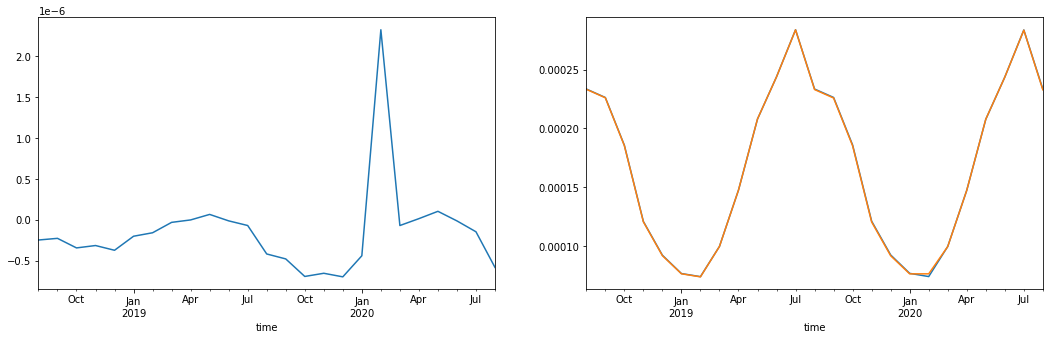

In [61]:
import pandas as pd

train_data, validation_data = utils.ts_train_test_split(nh3, .9)
validation_data = validation_data

best_model = ARIMA(train_data, order=min_ccfoos_model['order'], seasonal_order=min_ccfoos_model['seasonal_order']).fit()
predictions, errors = multiple_forecasts(model=best_model, ts=validation_data, times=len(validation_data), refit=False)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors, index=validation_data.index).plot(ax=axs[0])

pd.Series(predictions, index=validation_data.index).plot(ax=axs[1])
validation_data.plot(ax=axs[1])
plt.show()

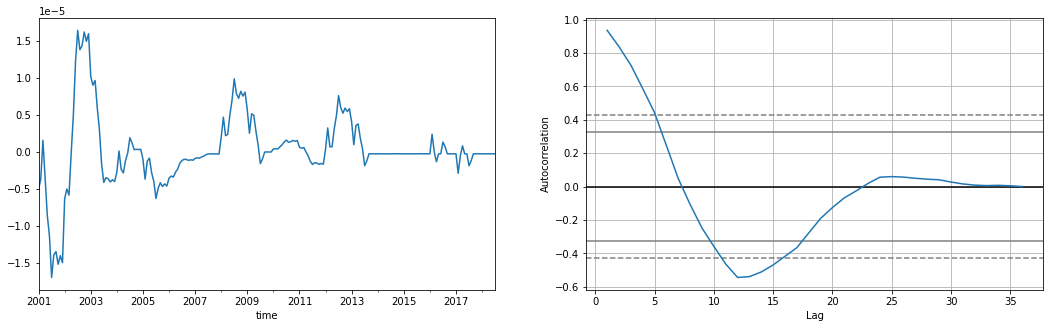

In [62]:
from pandas.plotting import autocorrelation_plot

errors = best_model.resid

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors[12:]).plot(ax=axs[0])
autocorrelation_plot(errors[12:48], ax=axs[1])
plt.show()

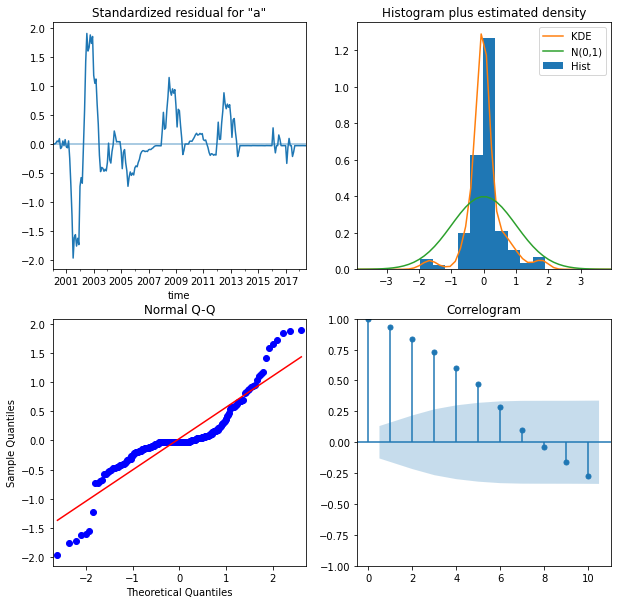

In [63]:
best_model.plot_diagnostics(figsize=(10,10))
plt.show()

Excluding the first 12 months due to seasonality

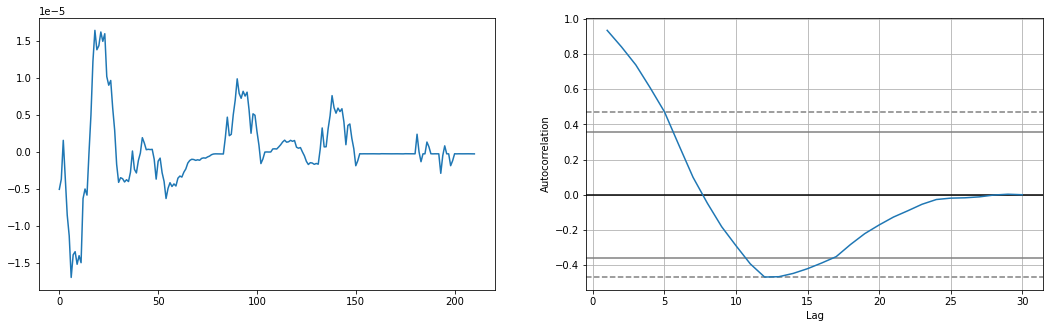

In [64]:
predictions = best_model.predict(start=train_data.index[12], end=train_data.index[-1])

errors = train_data[12:].values - predictions.values

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors).plot(ax=axs[0])
autocorrelation_plot(errors[:30], ax=axs[1])
plt.show()

In [65]:
#  null hypothesis is of no heteroskedasticity

result = best_model.test_heteroskedasticity(method=None)
if result[0, 1] < 0.05: print('Eteroschedastici')
result

Eteroschedastici


array([[8.50856549e-02, 1.24226270e-21]])

In [66]:
best_model.test_normality('jarquebera')

array([[1.60697971e+02, 1.27314813e-35, 2.50303814e-01, 7.12846714e+00]])

In [67]:
print(best_model.pvalues)

const       0.789215
ar.L1       0.000000
ar.L2       0.000000
ar.L5       0.000000
ar.L6       0.000000
ma.L1       0.999999
ma.L2       1.000000
ma.L3       1.000000
ma.L4       0.999999
ma.L5       1.000000
ma.L6       1.000000
ar.S.L12    0.000000
sigma2      0.584713
dtype: float64


In [68]:
best_model.params

const       1.634117e-04
ar.L1      -9.809457e-02
ar.L2       4.061411e-01
ar.L5      -6.050348e-01
ar.L6      -3.570692e-01
ma.L1       5.175836e-11
ma.L2       4.386743e-11
ma.L3       3.978154e-11
ma.L4       3.206415e-11
ma.L5       3.054247e-11
ma.L6       1.731658e-11
ar.S.L12    9.994619e-01
sigma2      7.482125e-11
dtype: float64

In [69]:
best_model.test_serial_correlation('boxpierce', lags=12)[0][1]

array([5.93703293e-044, 3.23878454e-076, 1.10922313e-100, 3.94466528e-117,
       6.59125341e-127, 9.76225253e-130, 3.66686608e-129, 3.06333126e-128,
       1.45442206e-128, 3.99619708e-131, 7.76363654e-137, 1.18215422e-145])

In [70]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(errors, model_df=len(best_model.param_names)-1)[1]

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       4.33197954e-163, 9.02285264e-170, 1.70899568e-175, 6.51601393e-180,
       3.70747315e-183, 1.92750346e-184, 3.10534568e-184, 1.89836466e-183,
       1.90520592e-182, 1.88260416e-181, 1.26800684e-180, 4.47919126e-180,
       1.65780574e-179, 9.59926281e-179, 6.89742343e-178, 5.36873867e-177,
       3.79682851e-176, 1.63184071e-175, 2.07437426e-175, 1.16447725e-175,
       3.16542393e-176, 4.20204337e-177, 2.23735917e-178, 3.35355800e-180,
       1.35378303e-181, 3.39635788e-182, 2.37184819e-182, 3.91434554e-182])

Apply the max nh3 emission point model on the min nh3 emission point

In [71]:
train_data, validation_data = utils.ts_train_test_split(nh3_min, .75)

best_model = ARIMA(train_data, order=min_aic_model['order'], seasonal_order=min_aic_model['seasonal_order']).fit()
predictions, errors = multiple_forecasts(model=best_model, ts=validation_data, times=len(validation_data), refit=False)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors, index=validation_data.index).plot(ax=axs[0])

pd.Series(predictions, index=validation_data.index).plot(ax=axs[1])
validation_data.plot(ax=axs[1])
plt.show()

NameError: name 'nh3_min' is not defined